In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Sklearn Modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Deep Learning Modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Configure plotting style and suppress warnings
sns.set_style("whitegrid")
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


In [11]:
# --- 1. Data Loading and Initial Summary ---
FILE_PATH = 'DiaBD_A Diabetes Dataset for Enhanced Risk Analysis and Research in Bangladesh.csv'
try:
    df = pd.read_csv(FILE_PATH)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print(f"Error: File not found at '{FILE_PATH}'. "
          f"Please ensure the CSV file is in the same directory as this notebook.")

print("\n" + "="*50)
print("      INITIAL DATA SUMMARY")
print("="*50)
df.info()
print("\nTarget variable distribution:")
print(df['diabetic'].value_counts())


Dataset loaded successfully!

      INITIAL DATA SUMMARY
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5288 entries, 0 to 5287
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     5288 non-null   int64  
 1   gender                  5288 non-null   object 
 2   pulse_rate              5288 non-null   int64  
 3   systolic_bp             5288 non-null   int64  
 4   diastolic_bp            5288 non-null   int64  
 5   glucose                 5288 non-null   float64
 6   height                  5288 non-null   float64
 7   weight                  5288 non-null   float64
 8   bmi                     5288 non-null   float64
 9   family_diabetes         5288 non-null   int64  
 10  hypertensive            5288 non-null   int64  
 11  family_hypertension     5288 non-null   int64  
 12  cardiovascular_disease  5288 non-null   int64  
 13  stroke                  5288 non-nul

In [12]:
# --- 2. Data Cleaning and Missing Value Imputation ---
print("\n" + "="*50)
print("      DATA CLEANING & IMPUTATION")
print("="*50)

# Encode gender (Male=1, Female=0)
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
    
# Encode target variable 'diabetic' (No=0, Yes=1)
le = LabelEncoder()
df['diabetic'] = le.fit_transform(df['diabetic'])

# Columns where 0s are biologically implausible and treated as missing
cols_to_replace = ['systolic_bp', 'diastolic_bp', 'glucose', 'height', 'weight', 'bmi']

print("Count of 0 values before replacement:")
print(df[cols_to_replace].eq(0).sum())

# Replace 0 values with the mean of the respective column
for col in cols_to_replace:
    mean_val = df[df[col] != 0][col].mean()
    df[col] = df[col].replace(0, mean_val)

print("\nCount of 0 values after replacement:")
print(df[cols_to_replace].eq(0).sum())
print("\nDescriptive statistics after imputation:")
print(df.describe().T)



      DATA CLEANING & IMPUTATION
Count of 0 values before replacement:
systolic_bp     0
diastolic_bp    0
glucose         1
height          0
weight          0
bmi             0
dtype: int64

Count of 0 values after replacement:
systolic_bp     0
diastolic_bp    0
glucose         0
height          0
weight          0
bmi             0
dtype: int64

Descriptive statistics after imputation:
                         count        mean        std    min      25%     50%  \
age                     5288.0   45.745651  13.422024  21.00   35.000   45.00   
gender                  5288.0    0.290469   0.454022   0.00    0.000    0.00   
pulse_rate              5288.0   76.626135  12.229319   5.00   69.000   76.00   
systolic_bp             5288.0  133.996596  22.231752  62.00  119.000  130.00   
diastolic_bp            5288.0   82.229576  12.479007  45.00   73.000   81.00   
glucose                 5288.0    7.565353   2.942543   0.04    6.000    6.93   
height                  5288.0    1.548

In [13]:
# --- 3. Feature Scaling and Data Splitting ---
X = df.drop('diabetic', axis=1)
y = df['diabetic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for feature names in RFE/Lasso steps
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print("\nData split and scaled successfully.")
print(f"Training set shape: {X_train_scaled_df.shape}")
print(f"Testing set shape: {X_test_scaled_df.shape}")



Data split and scaled successfully.
Training set shape: (4230, 14)
Testing set shape: (1058, 14)


In [14]:
# --- 4. Traditional ML: Logistic Regression (Baseline Model) ---
print("\n" + "="*50)
print("      LOGISTIC REGRESSION (BASELINE)")
print("="*50)
logreg_model = LogisticRegression(solver='liblinear', random_state=42)
logreg_model.fit(X_train_scaled_df, y_train)

y_pred_logreg = logreg_model.predict(X_test_scaled_df)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

print(f"\nLogistic Regression Accuracy: {accuracy_logreg:.4f}")
print("\nClassification Report (Baseline):\n", classification_report(y_test, y_pred_logreg))



      LOGISTIC REGRESSION (BASELINE)

Logistic Regression Accuracy: 0.9357

Classification Report (Baseline):
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       990
           1       0.50      0.13      0.21        68

    accuracy                           0.94      1058
   macro avg       0.72      0.56      0.59      1058
weighted avg       0.91      0.94      0.92      1058



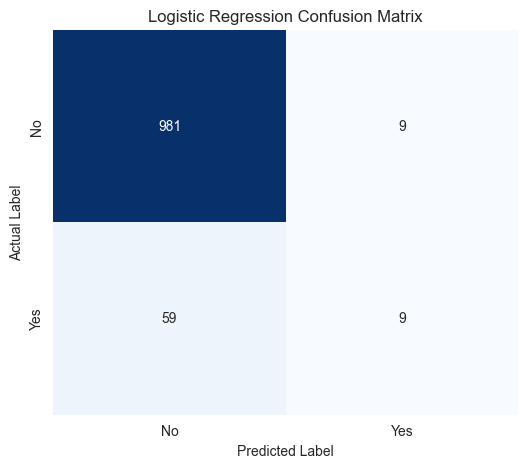

In [15]:
# Visualize the confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show() 


In [16]:
# --- 5. Feature Selection: Recursive Feature Elimination (RFE) ---
print("\n" + "="*50)
print("      RFE-OPTIMIZED LOGISTIC REGRESSION")
print("="*50)
    
rfe = RFE(estimator=LogisticRegression(solver='liblinear', random_state=42), n_features_to_select=8)
rfe.fit(X_train_scaled_df, y_train)

selected_rfe_features = X_train_scaled_df.columns[rfe.support_]
print(f"RFE Selected Features (Top 8): {list(selected_rfe_features)}")

# Train RFE-optimized model
X_train_rfe = X_train_scaled_df[selected_rfe_features]
X_test_rfe = X_test_scaled_df[selected_rfe_features]

logreg_rfe = LogisticRegression(solver='liblinear', random_state=42)
logreg_rfe.fit(X_train_rfe, y_train)

y_pred_rfe = logreg_rfe.predict(X_test_rfe)
accuracy_rfe = accuracy_score(y_test, y_pred_rfe)

print(f"\nRFE-Optimized LogReg Accuracy: {accuracy_rfe:.4f}")
print("\nClassification Report (RFE-Optimized LogReg):\n", classification_report(y_test, y_pred_rfe))



      RFE-OPTIMIZED LOGISTIC REGRESSION
RFE Selected Features (Top 8): ['age', 'pulse_rate', 'diastolic_bp', 'glucose', 'weight', 'family_diabetes', 'hypertensive', 'family_hypertension']

RFE-Optimized LogReg Accuracy: 0.9348

Classification Report (RFE-Optimized LogReg):
               precision    recall  f1-score   support

           0       0.94      0.99      0.97       990
           1       0.47      0.12      0.19        68

    accuracy                           0.93      1058
   macro avg       0.71      0.55      0.58      1058
weighted avg       0.91      0.93      0.92      1058



In [17]:
# --- 6. Feature Selection: LassoCV Regularization and Coefficient Analysis ---
print("\n" + "="*50)
print("      LASSO REGULARIZATION & COEFFICIENT ANALYSIS")
print("="*50)

# Initialize LassoCV to find the best alpha
lassocv = LassoCV(cv=5, random_state=42, max_iter=10000).fit(X_train_scaled_df, y_train)
best_alpha = lassocv.alpha_
print(f"Best Alpha found by LassoCV: {best_alpha:.4f}")

# Extract coefficients
lasso_coef = pd.Series(lassocv.coef_, index=X_train_scaled_df.columns)
print("\nLasso Coefficients (Feature Importance):\n", lasso_coef.sort_values(ascending=False))

selected_lasso_features = lasso_coef[lasso_coef != 0].index.tolist()
print(f"\nLasso Selected Features (non-zero coef): {selected_lasso_features}")



      LASSO REGULARIZATION & COEFFICIENT ANALYSIS
Best Alpha found by LassoCV: 0.0049

Lasso Coefficients (Feature Importance):
 hypertensive              0.075849
glucose                   0.063939
weight                    0.009186
cardiovascular_disease    0.006543
diastolic_bp              0.006147
pulse_rate                0.000874
systolic_bp               0.000000
gender                    0.000000
age                       0.000000
height                    0.000000
family_diabetes          -0.000000
bmi                       0.000000
family_hypertension      -0.000000
stroke                   -0.000000
dtype: float64

Lasso Selected Features (non-zero coef): ['pulse_rate', 'diastolic_bp', 'glucose', 'weight', 'hypertensive', 'cardiovascular_disease']


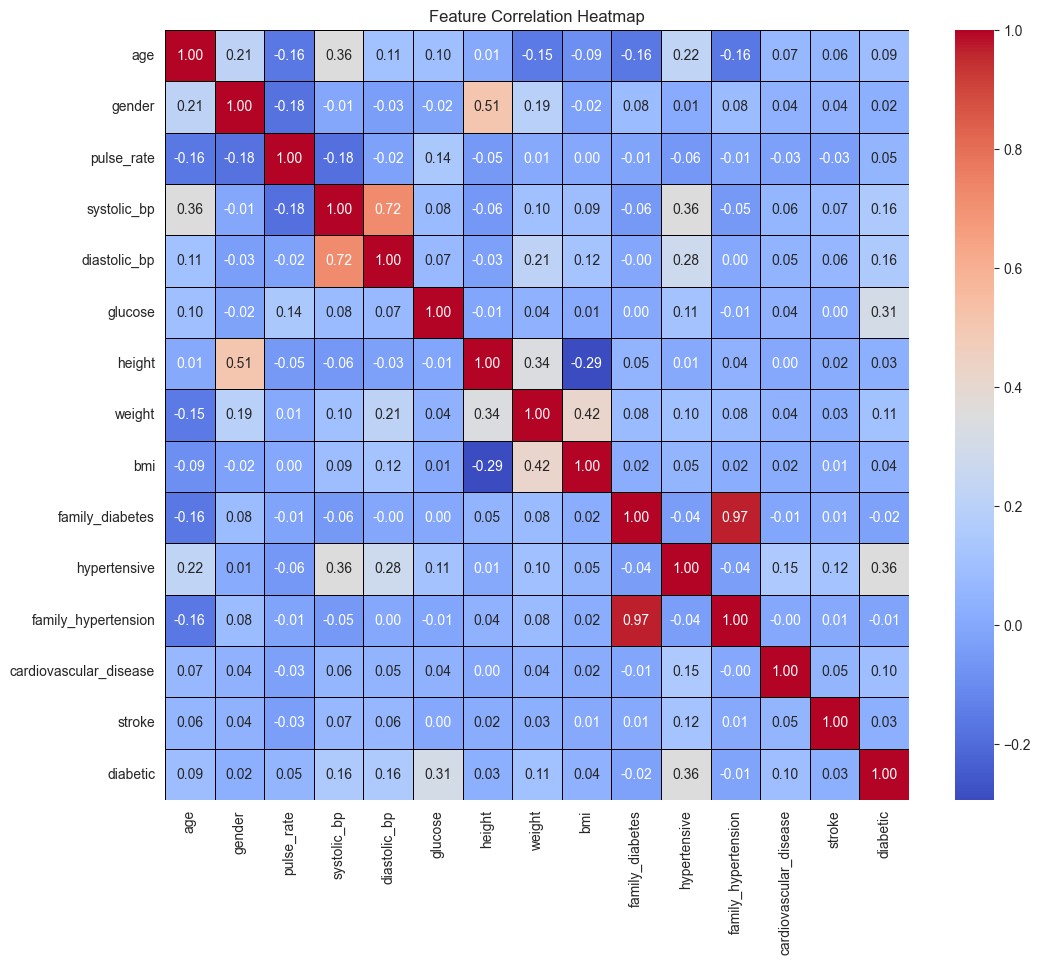

In [18]:
# Create and Visualize the Correlation Heatmap
df_corr = df.copy()
corr_matrix = df_corr.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black')
plt.title('Feature Correlation Heatmap')
plt.show() 


In [19]:
# --- 7. Deep Learning Model (Neural Network) Definition ---
print("\n" + "="*50)
print("      DEEP LEARNING MODEL (NEURAL NETWORK)")
print("="*50)
    
input_dim = X_train_scaled_df.shape[1] # Number of features

# Build the deep learning model
dl_model = Sequential([
    Dense(32, activation='relu', input_shape=(input_dim,)),  
    Dense(16, activation='relu'),                             
    Dense(1, activation='sigmoid')                            # Output layer for binary classification
])

# Compile the model
dl_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

dl_model.summary()


      DEEP LEARNING MODEL (NEURAL NETWORK)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,025 (4.00 KB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model 
print("\nTraining Deep Learning Model...")
history = dl_model.fit(X_train_scaled_df, y_train,
                       epochs=50,
                       batch_size=16,
                       validation_split=0.1, 
                       verbose=0) 

# Evaluate the model
loss_dl, accuracy_dl = dl_model.evaluate(X_test_scaled_df, y_test, verbose=0)
print(f"\nDeep Learning Model Test Accuracy: {accuracy_dl:.4f}")
print(f"Deep Learning Model Test Loss: {loss_dl:.4f}")

# Make predictions and get the classification report
y_pred_proba_dl = dl_model.predict(X_test_scaled_df)
y_pred_dl = (y_pred_proba_dl > 0.5).astype(int)

print("\nClassification Report (Deep Learning):\n", classification_report(y_test, y_pred_dl))



Training Deep Learning Model...

Deep Learning Model Test Accuracy: 0.9319
Deep Learning Model Test Loss: 0.2047
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report (Deep Learning):
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       990
           1       0.43      0.19      0.27        68

    accuracy                           0.93      1058
   macro avg       0.69      0.59      0.61      1058
weighted avg       0.91      0.93      0.92      1058



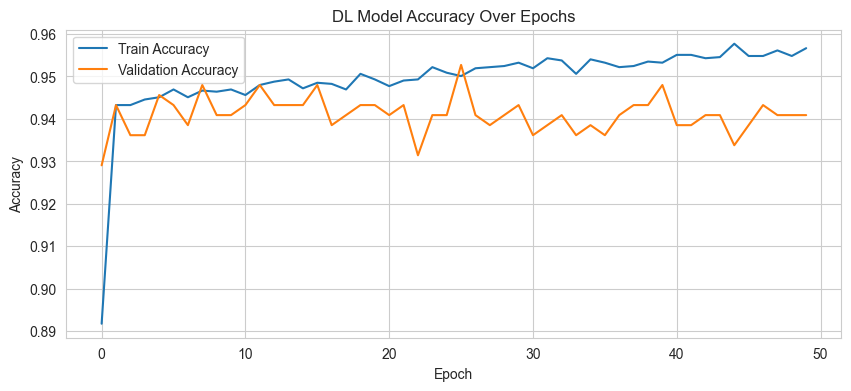


      FINAL MODEL COMPARISON
1. Baseline LogReg Accuracy: 0.9357
2. RFE LogReg Accuracy: 0.9348
3. Deep Learning Accuracy: 0.9319


In [21]:
# Visualize DL training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('DL Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Final Summary Comparison
print("\n" + "="*50)
print("      FINAL MODEL COMPARISON")
print("="*50)
print(f"1. Baseline LogReg Accuracy: {accuracy_logreg:.4f}")
print(f"2. RFE LogReg Accuracy: {accuracy_rfe:.4f}")
print(f"3. Deep Learning Accuracy: {accuracy_dl:.4f}")
print("="*50)

# The accuracy scores from this comparison should guide your final model selection!
